## PriorCVAE and PriorVAE model comparison

Plot the samples and covariance matrix from priorCVAE, priorVAE, and true prior. 

In [1]:
import os
import random
import yaml

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax.linen as nn

from priorCVAE.datasets import GPDataset
import priorCVAE.priors as priors
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params, generate_decoder_samples

import jax.config as config
config.update("jax_enable_x64", True)


## Load setup

In [2]:
prior_cvae_dir = "../arc_outputs/gp/etf1ntux/"
prior_vae_dir = "../arc_outputs/gp/97ypwdu9/"
n = 5000
n_samples_plot = 25

In [3]:
ls_list = jnp.linspace(0.2, 1, 5)

In [4]:
ls_list

Array([0.2, 0.4, 0.6, 0.8, 1. ], dtype=float64)

In [5]:
def load_model(model_dir):
    cfg_path = os.path.join(model_dir, "files", "config.yaml")
    with open(cfg_path, 'r') as file:
        cfg_data = yaml.safe_load(file)

    latent_dim = cfg_data["latent_dim"]["value"]
    dec_activation_fn = cfg_data["dec_activation"]["value"]["_target_"]
    dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])
    kernel = getattr(priors, cfg_data["data_generator"]["value"]["kernel"]["_target_"].split(".")[-1])
    
    x0 = cfg_data["x0"]["value"]
    x1 = cfg_data["x1"]["value"]
    n_data = cfg_data["n_data"]["value"]
    x = jnp.linspace(x0, x1, n_data)
    
    trained_decoder_params = load_model_params(os.path.join(model_dir, "model"))["decoder"]
    output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
    hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
    decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)
    
    gp_dataset = GPDataset(kernel=kernel(), x=x, sample_lengthscale=False)
    
    return decoder, trained_decoder_params, gp_dataset, latent_dim

## Load models

In [6]:
prior_cvae_decoder, prior_cvae_params, gp_dataset_cvae, latent_dim_cvae = load_model(prior_cvae_dir)
prior_vae_decoder, prior_vae_params, gp_dataset_vae, latent_dim_vae = load_model(prior_vae_dir)

In [7]:
assert latent_dim_cvae == latent_dim_vae
latent_dim = latent_dim_cvae

In [8]:
assert jnp.sum(gp_dataset_cvae.x) == jnp.sum(gp_dataset_vae.x)
assert type(gp_dataset_cvae.kernel) == type(gp_dataset_vae.kernel)

gp_dataset = gp_dataset_cvae
print(gp_dataset_cvae.kernel)

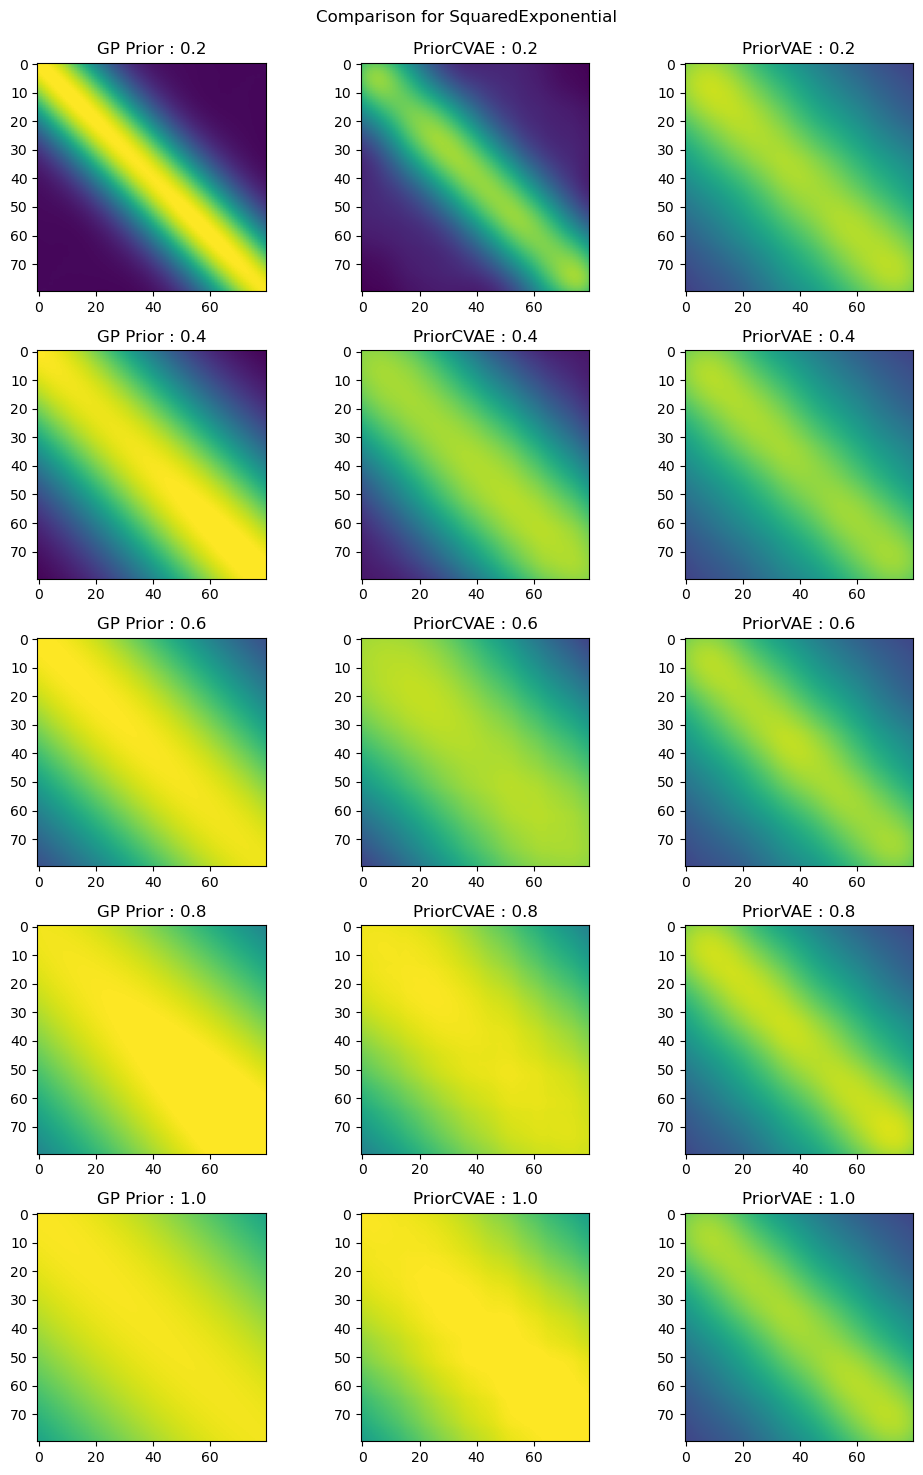

In [ ]:
fig, axs = plt.subplots(ls_list.shape[0], 3, figsize=(10, 15))
for i, ls in enumerate(ls_list):
    rows = i
    key = jax.random.PRNGKey(random.randint(0, 9999))
    
    c = ls*jnp.ones((n, 1))
    gp_dataset.kernel.lengthscale = ls
    
    _, gp_samples, _ = gp_dataset.simulatedata(n)
    prior_cvae_samples = generate_decoder_samples(key, decoder_params=prior_cvae_params, decoder=prior_cvae_decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    prior_vae_samples = generate_decoder_samples(key, decoder_params=prior_vae_params, decoder=prior_vae_decoder, 
                                           c=None, num_samples=n, latent_dim=latent_dim)
    
    prior_vae_samples = jnp.cov(prior_vae_samples.T) 
    prior_cvae_cov = jnp.cov(prior_cvae_samples.T)
    gp_cov = jnp.cov(gp_samples.T)
    
    axs[rows][0].imshow(gp_cov, vmin=0, vmax=1)
    axs[rows][1].imshow(prior_cvae_cov, vmin=0, vmax=1)
    axs[rows][2].imshow(prior_vae_samples, vmin=0, vmax=1)
    
    ls = round(ls, 2)
    axs[rows][0].set_title(f"GP Prior : {ls}")
    axs[rows][1].set_title(f"PriorCVAE : {ls}")
    axs[rows][2].set_title(f"PriorVAE : {ls}")

plt.suptitle(f"Comparison for {type(gp_dataset_cvae.kernel).__name__} \n")
plt.tight_layout()
plt.show()

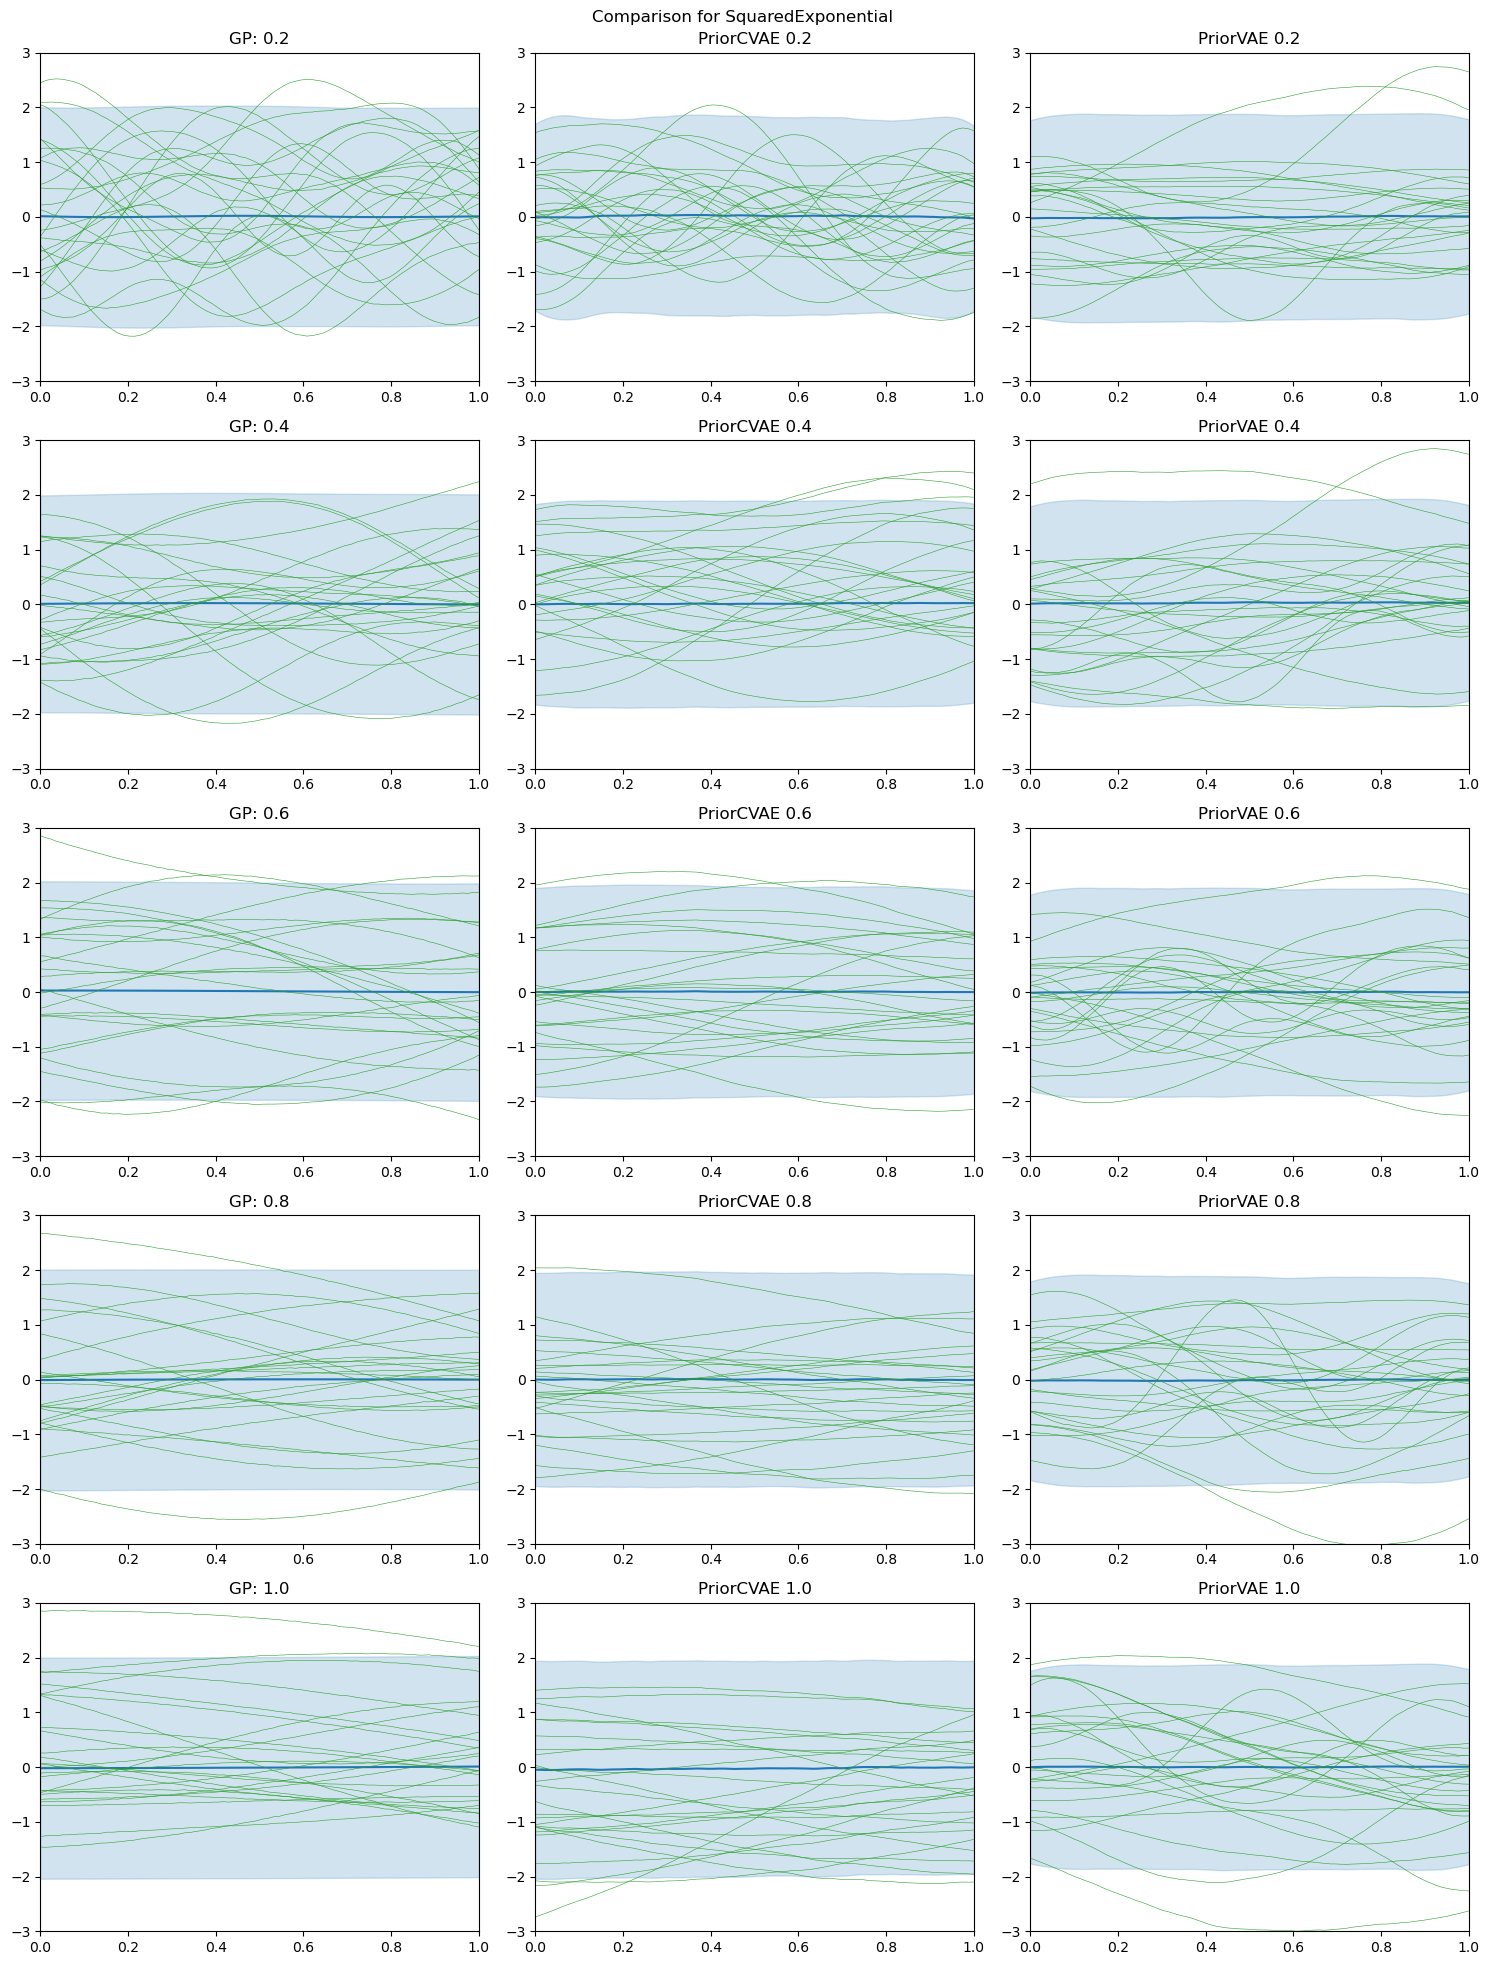

In [10]:
fig, axs = plt.subplots(ls_list.shape[0], 3, figsize=(15, 20))
for i, ls in enumerate(ls_list):
    
    rows = i
    key = jax.random.PRNGKey(random.randint(0, 9999))
    
    c = ls*jnp.ones((n, 1))
    
    x = gp_dataset.x
    
    # GP
    gp_dataset.kernel.lengthscale = ls
    _, gp_samples, _ = gp_dataset.simulatedata(n)
    gp_samples_mean = jnp.mean(gp_samples, axis=0)
    gp_samples_std = jnp.std(gp_samples, axis=0)
    axs[rows][0].plot(x, gp_samples_mean, c="tab:blue")
    axs[rows][0].fill_between(x, gp_samples_mean - 2 * gp_samples_std, 
                                 gp_samples_mean + 2 * gp_samples_std, color="tab:blue", alpha=0.2)
    for v in gp_samples[:n_samples_plot]:
        axs[rows][0].plot(x, v, c="tab:green", linewidth=0.4)
    axs[rows][0].set_ylim([-3, 3])
    axs[rows][0].set_xlim([x[0], x[-1]])
    
    # PriorCVAE
    cvae_samples = generate_decoder_samples(key, decoder_params=prior_cvae_params, decoder=prior_cvae_decoder, 
                                           c=c, num_samples=n, latent_dim=latent_dim)
    cvae_samples_mean = jnp.mean(cvae_samples, axis=0)
    cvae_samples_std = jnp.std(cvae_samples, axis=0)
    axs[rows][1].plot(x, cvae_samples_mean, c="tab:blue")
    axs[rows][1].fill_between(x, cvae_samples_mean - 2 * cvae_samples_std, 
                                 cvae_samples_mean + 2 * cvae_samples_std, color="tab:blue", alpha=0.2)
    for v in cvae_samples[:n_samples_plot]:
        axs[rows][1].plot(x, v, c="tab:green", linewidth=0.4)
    axs[rows][1].set_ylim([-3, 3])
    axs[rows][1].set_xlim([x[0], x[-1]])
    
    # PriorVAE
    vae_samples = generate_decoder_samples(key, decoder_params=prior_vae_params, decoder=prior_vae_decoder, 
                                           c=None, num_samples=n, latent_dim=latent_dim)
    vae_samples_mean = jnp.mean(vae_samples, axis=0)
    vae_samples_std = jnp.std(vae_samples, axis=0)
    axs[rows][2].plot(x, vae_samples_mean, c="tab:blue")
    axs[rows][2].fill_between(x, vae_samples_mean - 2 * vae_samples_std, 
                                 vae_samples_mean + 2 * vae_samples_std, color="tab:blue", alpha=0.2)
    for v in vae_samples[:n_samples_plot]:
        axs[rows][2].plot(x, v, c="tab:green", linewidth=0.4)
    axs[rows][2].set_ylim([-3, 3])
    axs[rows][2].set_xlim([x[0], x[-1]])
    
    ls = round(ls, 2)
    axs[rows][0].set_title(f"GP: {ls}")
    axs[rows][1].set_title(f"PriorCVAE {ls}")  
    axs[rows][2].set_title(f"PriorVAE {ls}")  

plt.suptitle(f"Comparison for {type(gp_dataset_cvae.kernel).__name__} \n")
plt.tight_layout()
plt.show()